# 1 Configuración del ambiente

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from IPython.display import display
from typing import List, Tuple, Union, Optional
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx
from pandas.api.types import is_period_dtype
import matplotlib.dates as mdates

pd.set_option ('display.max_columns', None)
pd.set_option ('display.max_rows', None)


# 2 Carga de datos limpios

In [178]:
# Cargar los datos del dataset procesados de 01_carga_limpieza
df = pd.read_parquet(r'C:\Users\xavie\Documents\PROYECTOS\fraud-detection-ml\data\processed\01_df_limpieza.parquet')
print("Dataset cargado correctamente")
print(f"Forma del dataset: {df.shape}")

Dataset cargado correctamente
Forma del dataset: (1463837, 39)


In [179]:
df_ind_gestion = df.copy()
df_ind_f = df.copy()

# 3. Indicadores de Gestión (RT / NRT)

## Evaluación de reglas RT (declinación/alerta):

-Las reglas RT permiten declinar transacciones en función de los parámetros definidos en su configuración. Estas reglas pueden ser diseñadas para que generen alertas o no, sin embargo, resulta indispensable evaluar de forma continua la efectividad de dicha parametrización en tiempo real, a fin de garantizar que no se generen fricciòn en la experiencia del tarjetahabiente.

-Del análisis efectuado se evidencia que hasta agosto de 2024 las reglas RT presentaban altos niveles de falsos positivos, reflejando un esquema de parametrización con limitada precisión y un volumen elevado de alertas no asociadas a fraudes reales.

-A partir de septiembre de 2024, se observa una mejora significativa en la efectividad del sistema, alcanzándose una relación inferior a 6:1 (seis alertas por cada fraude confirmado), lo que evidencia una mejor calibración y ajuste de los parámetros de riesgo.

-Sin embargo, se identificaron picos puntuales en diciembre de 2024, abril de 2025 y junio de 2025, donde la relación FP/TP superó el 9:1, indicando una reducción temporal en la precisión. Aunque estos valores podrian estar distante de detecciòn en tiempo real.

-Revisar las reglas con mayores desviaciones, a fin de consolidar una mayor precisión y efectividad en la detección de fraudes y reducciòn de falsos positivos.

In [180]:
codigos_respuesta = ['59']
df_alertas_rt = df_ind_gestion[df_ind_gestion['DE39_Respuesta_ISO'].isin(codigos_respuesta)]
# Parámetro define años que deseas analizar.
years = [2023,2024,2025]  #None para mostrar todos

In [181]:


# --- Filtro por año(s) ---
if years is None:
    df_filtrado = df_alertas_rt.copy()
else:
    df_filtrado = df_alertas_rt[df_alertas_rt['year'].isin(years)]

# --- Parámetros centrales: personaliza aquí lo que desees agrupar o pivotear ---
columnas_groupby = ['canal', 'Fraude', 'mes_year']  # Puedes cambiar 'trimestre' por 'mes' o agregar/quitar columnas
columnas_pivot_index = ['canal', 'Fraude']           # Identificadores para las filas de la tabla pivot
columna_pivot_columns = 'mes_year'                   # Columna para las columnas pivot (puede ser 'mes')
columna_valor = 'n_alertas_rt'                       # Valor que se va a resumir en el pivot

# --- Agrupación dinámica ---
cuadro_base = (
    df_filtrado
    .groupby(columnas_groupby, as_index=False)
    .size()
    .rename(columns={'size': columna_valor})
)

# --- Pivotear con variables dinámicas ---
cuadro_pivote = (
    cuadro_base
    .pivot(index=columnas_pivot_index, columns=columna_pivot_columns, values=columna_valor)
    .fillna(0)
    .astype(int)
)

# Total por fila
cuadro_pivote['Total'] = cuadro_pivote.sum(axis=1)

# Columnas de período (excluye 'Total')
cols_periodo = [c for c in cuadro_pivote.columns if c != 'Total']

# Sumar Falsos Positivos (Fraude==0) y Verdaderos Positivos (Fraude==1)
fp_periodo = cuadro_pivote.xs(0, level='Fraude')[cols_periodo].sum(axis=0)
tp_periodo = cuadro_pivote.xs(1, level='Fraude')[cols_periodo].sum(axis=0)

# Calcular ratio FP/TP por período
ratio_periodo = (fp_periodo / tp_periodo.replace(0, np.nan)).round(1)

# Calcular ratio global
fp_total = cuadro_pivote.xs(0, level='Fraude')['Total'].sum()
tp_total = cuadro_pivote.xs(1, level='Fraude')['Total'].sum()
ratio_total = np.nan if tp_total == 0 else round(fp_total / tp_total, 1)

# Agregar fila de ratios de Falsos Positivos
fila_fp = pd.concat([ratio_periodo, pd.Series({'Total': ratio_total})])
fila_fp.name = f'Falsos positivos (FP/TP) - {years if years else "Todos los años"}'

# Unir la fila final
cuadro_final = pd.concat([cuadro_pivote, fila_fp.to_frame().T])

display(cuadro_final)



,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,Total
"(CNP, 0)",243.0,2463.0,2851.0,2886.0,2513.0,2138.0,1879.0,1713.0,1280.0,1658.0,1423.0,640.0,2014.0,1853.0,1395.0,1211.0,1672.0,1638.0,1675.0,1632.0,1245.0,1146.0,37168.0
"(CNP, 1)",1.0,40.0,107.0,100.0,71.0,52.0,32.0,8.0,39.0,57.0,133.0,21.0,600.0,648.0,251.0,120.0,271.0,261.0,512.0,126.0,402.0,125.0,3977.0
"(CP, 0)",1.0,18.0,16.0,29.0,13.0,1.0,13.0,3.0,6.0,1.0,6.0,8.0,7.0,11.0,4.0,4.0,0.0,0.0,6.0,34.0,4.0,0.0,185.0
"Falsos positivos (FP/TP) - [2023, 2024, 2025]",244.0,62.0,26.8,29.2,35.6,41.1,59.1,214.5,33.0,29.1,10.7,30.9,3.4,2.9,5.6,10.1,6.2,6.3,3.3,13.2,3.1,9.2,9.4


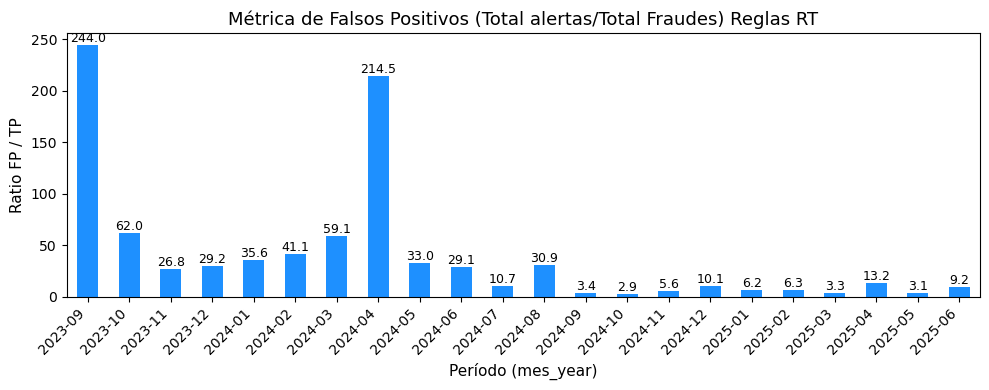

In [182]:
plt.figure(figsize=(10,4))
bars = ratio_periodo.sort_index().plot(kind='bar', color='dodgerblue')

for p in bars.patches:
    bars.annotate(f'{p.get_height():.1f}', 
                  (p.get_x() + p.get_width()/2, p.get_height()), 
                  ha='center', va='bottom', fontsize=9)

plt.title('Métrica de Falsos Positivos (Total alertas/Total Fraudes) Reglas RT')
plt.xlabel('Período (mes_year)')
plt.ylabel('Ratio FP / TP')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Alertas NRT - Efectividad

Las reglas NRT cumplen una función de alertamiento preventivo, sin declinar operaciones, por lo que su efectividad se mide según la correspondencia entre las alertas generadas y los fraudes confirmados.

- Durante el período analizado, las operaciones sin alerta (NO_ALERTA) representaron en promedio más del 94 %, mientras que las alertas emitidas (SI_ALERTA) se mantuvieron entre 4 % y 6 %, reflejando una parametrización estable y de bajo impacto operativo.

- Dentro del grupo SI_ALERTA, entre el 10 % y 20 % de las alertas correspondieron a fraudes reales, alcanzando picos del 25 % en algunos meses. En contraste, los fraudes fuera de alerta fueron mínimos (<1 %), evidenciando una adecuada capacidad de detección y una baja tasa de omisión.

- En conjunto, las reglas NRT muestran una efectividad consistente, con buen equilibrio entre sensibilidad y precisión, recomendándose mantener la revisión periódica de umbrales y condiciones de disparo para fortalecer su desempeño.

In [183]:
df_ind_gestion.groupby('Regla_nrt')['Estado'].value_counts()

Regla_nrt  Estado
NO_ALERTA  None      1340442
           F            1196
SI_ALERTA  D          108947
           F            7933
           I            4838
           S             481
Name: count, dtype: int64

In [184]:
filtro = df_ind_gestion['year'].isin([2023,2024,2025])  # Filtra los años deseados

In [185]:
def agrupar_estado(df, filtro, col_estado='Regla_nrt', col_mes='mes_year'):
    """
    Agrupa los registros por estado y mes.
    Parámetros:
        df: DataFrame fuente
        filtro: condición booleana para filtrar datos
        col_estado: columna con estado de alerta
        col_mes: columna con mes/año
    Retorna:
        Tabla agrupada por estado y mes.
    """
    return (
        df[filtro]
        .groupby([col_estado, col_mes])
        .size()
        .unstack(fill_value=0)
    )

def porcentaje_distribucion(tabla):
    """
    Calcula el porcentaje que cada estado aporta en cada mes con un decimal.
    Parámetros:
        tabla: DataFrame con conteos por estado y mes
    Retorna:
        DataFrame con porcentajes por estado.
    """
    return (tabla.div(tabla.sum(axis=0), axis=1) * 100).round(1)

def agrupar_estado_fraude(df, filtro, col_estado='Regla_nrt', col_fraude='Fraude', col_mes='mes_year'):
    """
    Agrupa los registros por estado, fraude y mes.
    Parámetros:
        df: DataFrame fuente
        filtro: condición booleana
        col_estado: columna con estado de alerta
        col_fraude: columna de fraude
        col_mes: columna de mes/año
    Retorna:
        Tabla agrupada por estado, fraude y mes.
    """
    return (
        df[filtro]
        .groupby([col_estado, col_fraude, col_mes])
        .size()
        .unstack(fill_value=0)
    )

def porcentaje_fraude_en_estado(tabla_estado_fraude):
    """
    Calcula el porcentaje de fraude interno por estado y mes (solo un decimal).
    Parámetros:
        tabla_estado_fraude: DataFrame con conteos
    Retorna:
        DataFrame con porcentaje de fraude interno por estado y mes.
    """
    totales_por_estado = tabla_estado_fraude.groupby(level=0).sum()
    return (tabla_estado_fraude.div(totales_por_estado, level=0) * 100).round(1)

# Uso:
tabla_estado = agrupar_estado(df_ind_gestion, filtro)
porc_estado = porcentaje_distribucion(tabla_estado)
tabla_estado_fraude = agrupar_estado_fraude(df_ind_gestion, filtro)
porc_fraude_en_estado = porcentaje_fraude_en_estado(tabla_estado_fraude)


In [186]:
display(tabla_estado)
display(porc_estado)
display(tabla_estado_fraude)
display(porc_fraude_en_estado)

mes_year,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06
Regla_nrt,,,,,,,,,,,,,,,,,,,,,,,
NO_ALERTA,59561,49236,81859,72076,65634,59242,57547,61152,55070,57055,55046,53952,61065,56883,55599,52912,57247,54870,51111,55511,55532,57936,55542
SI_ALERTA,8707,6820,7610,8625,9111,7470,7357,8591,7146,5750,5783,6834,1122,3098,3024,2745,2682,3618,3657,3522,3114,3232,2581


mes_year,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06
Regla_nrt,,,,,,,,,,,,,,,,,,,,,,,
NO_ALERTA,87.2,87.8,91.5,89.3,87.8,88.8,88.7,87.7,88.5,90.8,90.5,88.8,98.2,94.8,94.8,95.1,95.5,93.8,93.3,94.0,94.7,94.7,95.6
SI_ALERTA,12.8,12.2,8.5,10.7,12.2,11.2,11.3,12.3,11.5,9.2,9.5,11.2,1.8,5.2,5.2,4.9,4.5,6.2,6.7,6.0,5.3,5.3,4.4


mes_year          2023-08  2023-09  2023-10  2023-11  2023-12  2024-01  \
Regla_nrt Fraude                                                         
NO_ALERTA 0         59508    49209    81839    72035    65597    59216   
          1            53       27       20       41       37       26   
SI_ALERTA 0          8276     6700     7541     8453     8884     7309   
          1           431      120       69      172      227      161   

mes_year          2024-02  2024-03  2024-04  2024-05  2024-06  2024-07  \
Regla_nrt Fraude                                                         
NO_ALERTA 0         57519    61117    55058    57011    54972    53925   
          1            28       35       12       44       74       27   
SI_ALERTA 0          7270     8512     7081     5669     5644     6586   
          1            87       79       65       81      139      248   

mes_year          2024-08  2024-09  2024-10  2024-11  2024-12  2025-01  \
Regla_nrt Fraude                                                         
NO_ALERTA 0         61008    56755    55546    52872    57216    54791   
          1            57      128       53       40       31       79   
SI_ALERTA 0           981     2244     2071     2370     2411     3003   
          1           141      854      953      375      271      615   

mes_year          2025-02  2025-03  2025-04  2025-05  2025-06  
Regla_nrt Fraude                                               
NO_ALERTA 0         51082    55423    55470    57777    55496  
          1            29       88       62      159       46  
SI_ALERTA 0          3162     2732     2797     2346     2224  
          1           495      790      317      886      357

mes_year          2023-08  2023-09  2023-10  2023-11  2023-12  2024-01  \
Regla_nrt Fraude                                                         
NO_ALERTA 0          99.9     99.9    100.0     99.9     99.9    100.0   
          1           0.1      0.1      0.0      0.1      0.1      0.0   
SI_ALERTA 0          95.0     98.2     99.1     98.0     97.5     97.8   
          1           5.0      1.8      0.9      2.0      2.5      2.2   

mes_year          2024-02  2024-03  2024-04  2024-05  2024-06  2024-07  \
Regla_nrt Fraude                                                         
NO_ALERTA 0         100.0     99.9    100.0     99.9     99.9     99.9   
          1           0.0      0.1      0.0      0.1      0.1      0.1   
SI_ALERTA 0          98.8     99.1     99.1     98.6     97.6     96.4   
          1           1.2      0.9      0.9      1.4      2.4      3.6   

mes_year          2024-08  2024-09  2024-10  2024-11  2024-12  2025-01  \
Regla_nrt Fraude                                                         
NO_ALERTA 0          99.9     99.8     99.9     99.9     99.9     99.9   
          1           0.1      0.2      0.1      0.1      0.1      0.1   
SI_ALERTA 0          87.4     72.4     68.5     86.3     89.9     83.0   
          1          12.6     27.6     31.5     13.7     10.1     17.0   

mes_year          2025-02  2025-03  2025-04  2025-05  2025-06  
Regla_nrt Fraude                                               
NO_ALERTA 0          99.9     99.8     99.9     99.7     99.9  
          1           0.1      0.2      0.1      0.3      0.1  
SI_ALERTA 0          86.5     77.6     89.8     72.6     86.2  
          1          13.5     22.4     10.2     27.4     13.8

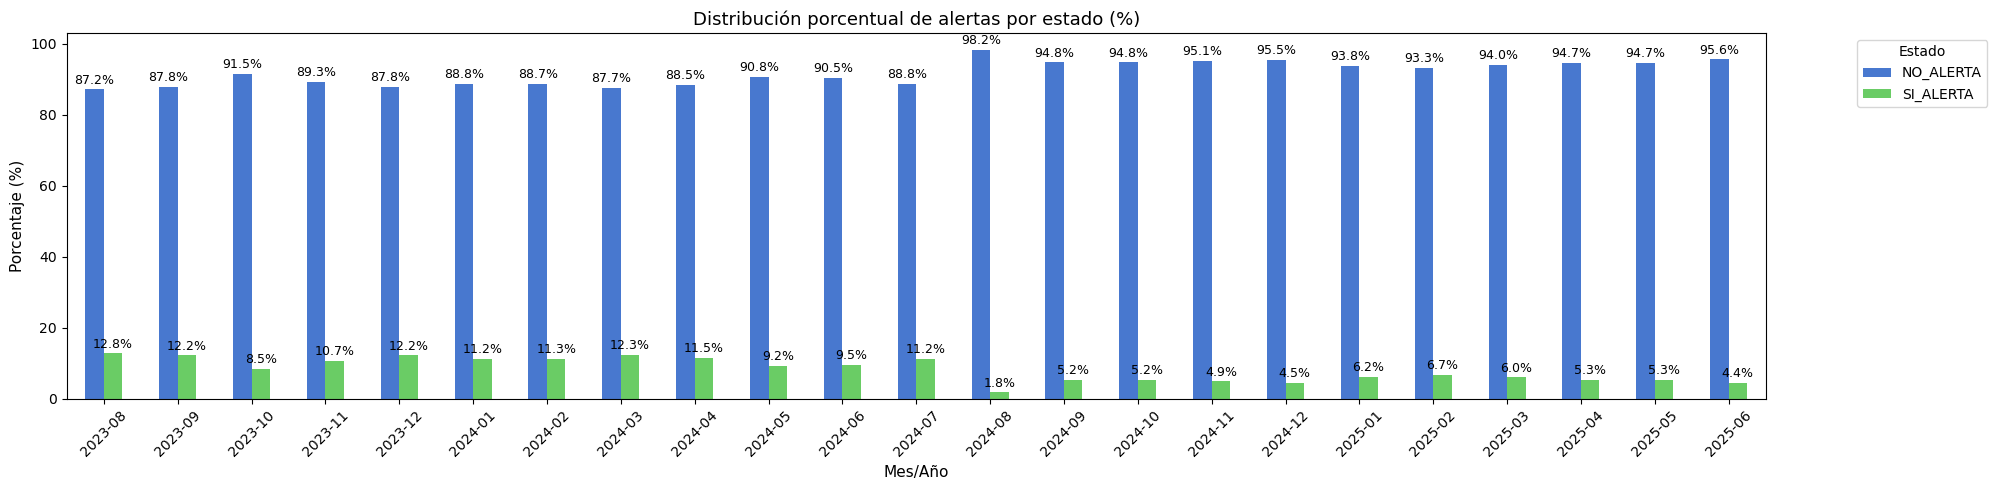

In [187]:
# --- Configuración general ---
plt.style.use('seaborn-v0_8-muted')  # estilo limpio y profesional
plt.rcParams['figure.figsize'] = (20, 5)
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

# Función auxiliar para agregar etiquetas sobre cada barra
def agregar_etiquetas(ax):
    for contenedor in ax.containers:
        ax.bar_label(contenedor, fmt='%.1f%%', label_type='edge', fontsize=9, padding=2)

# --- Gráfico 1: Distribución porcentual de alertas por estado ---
ax1 = porc_estado.T.plot(kind='bar', stacked=False)
ax1.set_title('Distribución porcentual de alertas por estado (%)')
ax1.set_ylabel('Porcentaje (%)')
ax1.set_xlabel('Mes/Año')
ax1.legend(title='Estado', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)
agregar_etiquetas(ax1)  # ← aquí se agregan las etiquetas
plt.tight_layout()
plt.show()



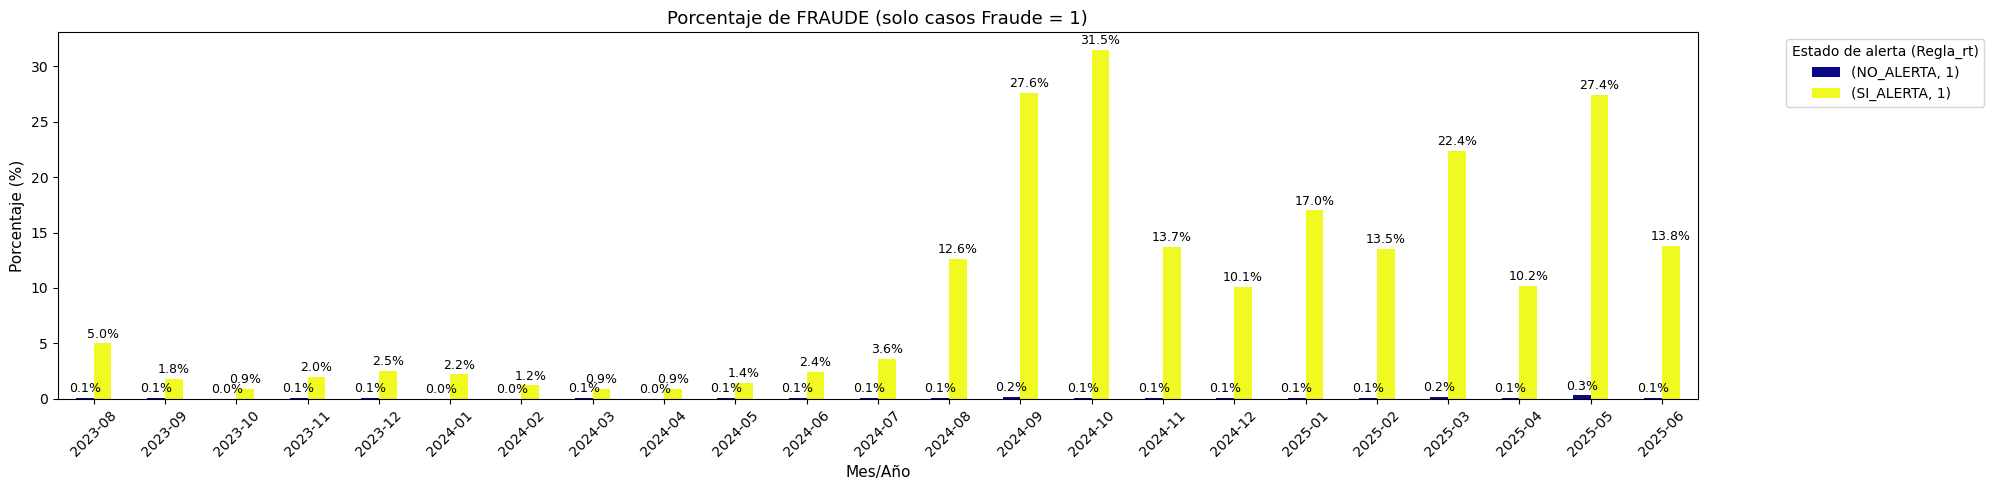

In [188]:
# --- Filtrar solo las filas donde Fraude == 1 ---
fraude_1 = porc_fraude_en_estado.loc[(slice(None), 1), :]

# --- Configuración general ---
plt.style.use('seaborn-v0_8-muted')
plt.rcParams['figure.figsize'] = (20, 5)
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

# --- Función auxiliar para etiquetas ---
def agregar_etiquetas(ax):
    for contenedor in ax.containers:
        ax.bar_label(contenedor, fmt='%.1f%%', label_type='edge', fontsize=9, padding=2)

# --- Gráfico: Porcentaje de fraude (solo FRAUDE = 1) ---
ax = fraude_1.T.plot(kind='bar', stacked=False, colormap='plasma')

ax.set_title('Porcentaje de FRAUDE (solo casos Fraude = 1)')
ax.set_ylabel('Porcentaje (%)')
ax.set_xlabel('Mes/Año')
ax.legend(title='Estado de alerta (Regla_rt)', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)
agregar_etiquetas(ax)
plt.tight_layout()
plt.show()


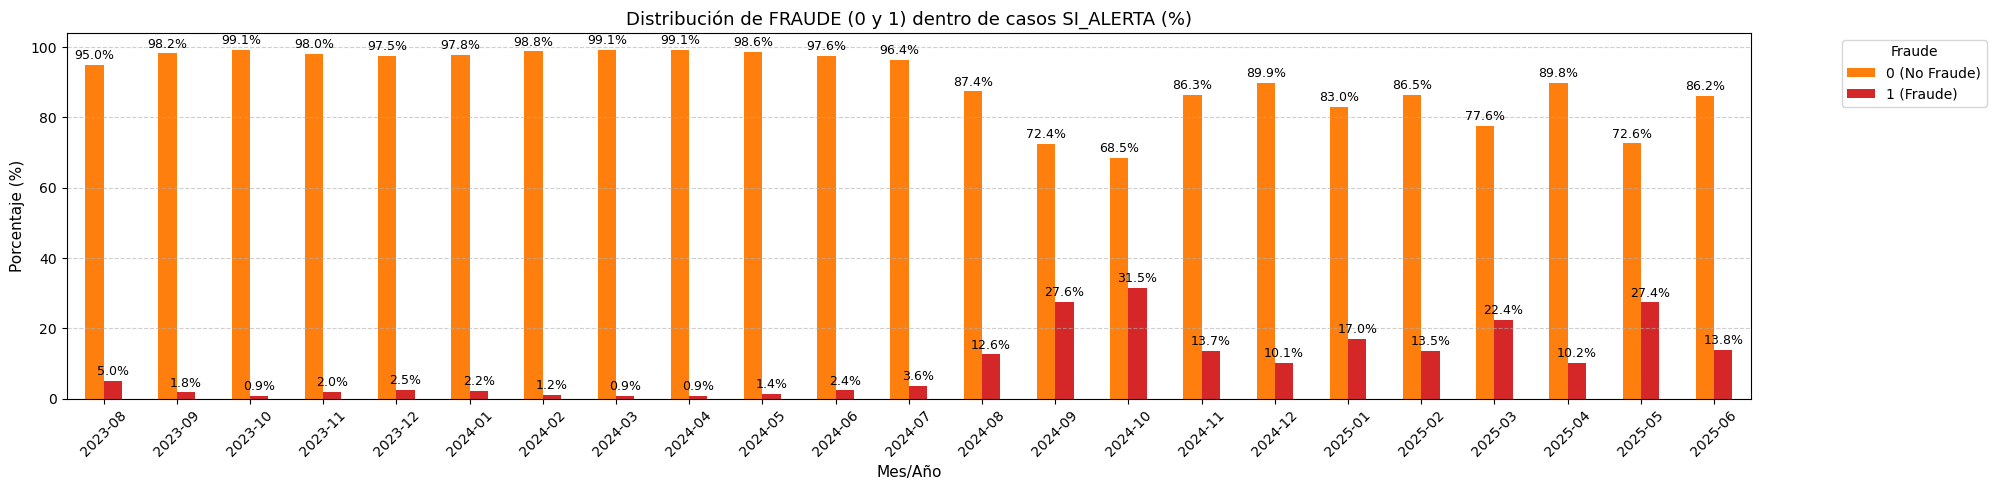

In [189]:
import matplotlib.pyplot as plt

# --- Filtrar solo los registros con SI_ALERTA ---
si_alerta = porc_fraude_en_estado.loc['SI_ALERTA', :]

# --- Configuración general ---
plt.style.use('seaborn-v0_8-muted')  # estilo limpio y profesional
plt.rcParams['figure.figsize'] = (20, 5)
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

# --- Función para agregar etiquetas ---
def agregar_etiquetas(ax):
    for contenedor in ax.containers:
        ax.bar_label(contenedor, fmt='%.1f%%', label_type='edge', fontsize=9, padding=2)

# --- Gráfico: Distribución de fraude dentro de SI_ALERTA ---
ax = si_alerta.T.plot(kind='bar', stacked=False, color=['tab:orange', 'tab:red'])
ax.set_title('Distribución de FRAUDE (0 y 1) dentro de casos SI_ALERTA (%)')
ax.set_ylabel('Porcentaje (%)')
ax.set_xlabel('Mes/Año')
ax.legend(title='Fraude', labels=['0 (No Fraude)', '1 (Fraude)'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Etiquetas de porcentaje sobre cada barra
agregar_etiquetas(ax)

plt.tight_layout()
plt.show()

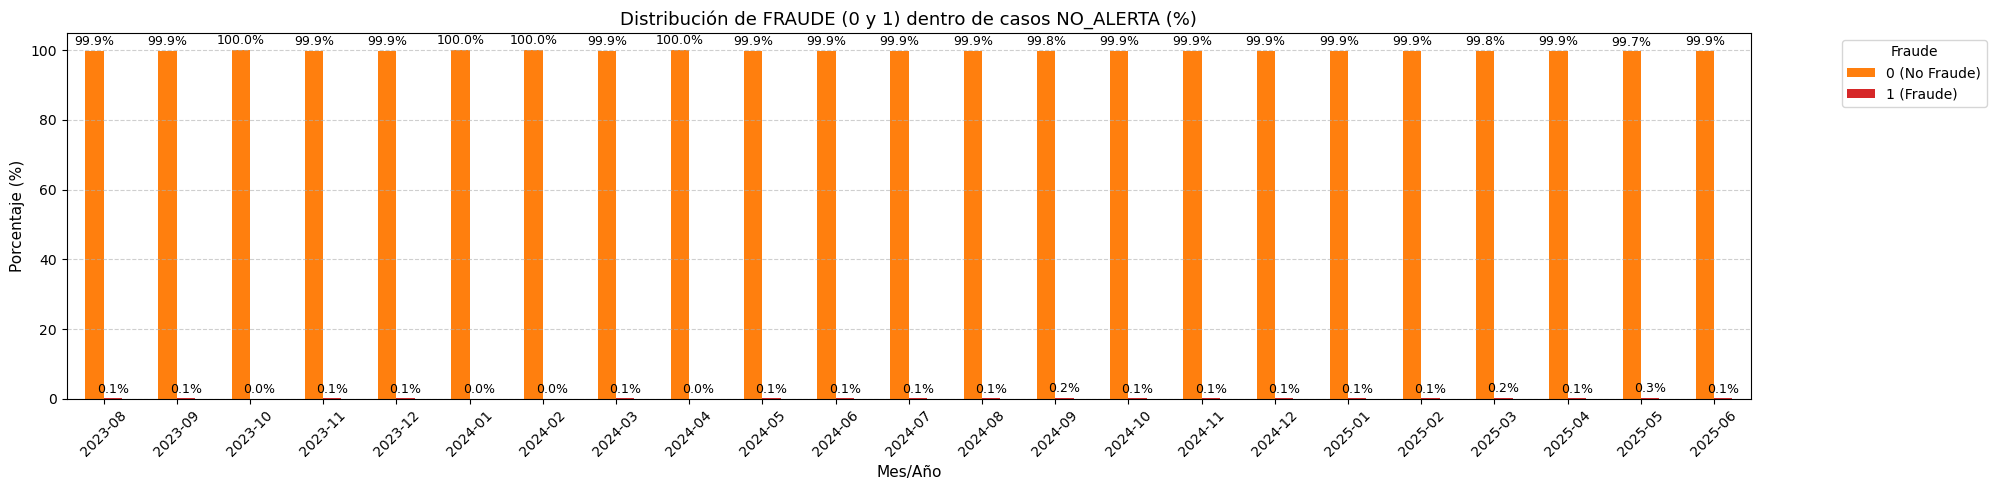

In [190]:
# --- Filtrar solo los registros con NO_ALERTA ---
si_alerta = porc_fraude_en_estado.loc['NO_ALERTA', :]

# --- Configuración general ---
plt.style.use('seaborn-v0_8-muted')  # estilo limpio y profesional
plt.rcParams['figure.figsize'] = (20, 5)
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

# --- Función para agregar etiquetas ---
def agregar_etiquetas(ax):
    for contenedor in ax.containers:
        ax.bar_label(contenedor, fmt='%.1f%%', label_type='edge', fontsize=9, padding=2)

# --- Gráfico: Distribución de fraude dentro de SI_ALERTA ---
ax = si_alerta.T.plot(kind='bar', stacked=False, color=['tab:orange', 'tab:red'])
ax.set_title('Distribución de FRAUDE (0 y 1) dentro de casos NO_ALERTA (%)')
ax.set_ylabel('Porcentaje (%)')
ax.set_xlabel('Mes/Año')
ax.legend(title='Fraude', labels=['0 (No Fraude)', '1 (Fraude)'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Etiquetas de porcentaje sobre cada barra
agregar_etiquetas(ax)

plt.tight_layout()
plt.show()

## Análisis individual por regla:

- El análisis de desempeño por regla evidencia una alta dispersión en la efectividad, con algunas reglas que alcanzan el 100 % de detección pero con muy bajo volumen de alertas, lo que refleja precisión alta pero escasa cobertura. En contraste, existen reglas con gran cantidad de alertas y nula detección de fraude, generando ruido operativo y reduciendo la eficiencia del sistema.

- Las colisiones entre reglas (activaciones simultáneas sobre un mismo evento) evidencian redundancia en la lógica de detección, provocando duplicidad de casos y distorsión en las métricas de efectividad. Este comportamiento sugiere la necesidad de revisar, consolidar o parametrizar las reglas que comparten condiciones similares.

- Durante junio de 2025, solo un grupo reducido de reglas concentró los aciertos efectivos, lo que confirma que pocas reglas aportan la mayoría de las detecciones reales. Las demás requieren recalibración o desactivación temporal para optimizar la tasa de acierto y reducir la carga operativa.


In [191]:
# Parámetros para el filtro


df_ind_gestion_regla = df_ind_gestion.copy()

df_ind_gestion_regla['mes_year'] = df_ind_gestion['mes_year'].astype(str)
df_ind_gestion_regla['year'] = df_ind_gestion['year'].astype(str)
df_ind_gestion_regla['mes_year'] = df_ind_gestion['mes_year'].astype(str)
df_ind_gestion_regla['trimestre'] = df_ind_gestion['trimestre'].astype(str)

columna_filtro = 'mes_year'                     # Variables: 'mes_year', 'year', 'trimestre'.
valores_filtro = []         # Lista de valores. Para todos lista vacía [], para year sin ''

if valores_filtro:
    df_filtrado = df_ind_gestion_regla[
        (df_ind_gestion_regla[columna_filtro].isin(valores_filtro)) &
        (df_ind_gestion_regla['Regla_nrt'] == 'SI_ALERTA')
    ]
else:
    df_filtrado = df_ind_gestion_regla[
        df_ind_gestion_regla['Regla_nrt'] == 'SI_ALERTA'
    ]

reglas_total = df_filtrado.groupby(['Regla', columna_filtro]).size().unstack(fill_value=0)
reglas_total.head(60)


mes_year,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06
Regla,,,,,,,,,,,,,,,,,,,,,,,
0,7715,5905,6519,7189,7836,6301,6458,7648,6668,5187,5307,6105,542,653,657,1245,1463,1862,1945,1475,1541,1722,1451
10,63,61,29,20,57,49,48,57,30,32,39,74,151,64,78,87,44,75,71,95,134,171,100
"10,11",2,0,4,7,7,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
"10,11,127",2,1,0,0,4,2,2,1,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0
"10,128",0,4,3,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"10,130",0,0,1,5,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"10,130,148",0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"10,148",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
"10,15",0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0


In [192]:
# Parámetros para el filtro
columna_filtro = 'mes_year'  # Variables posibles: 'mes_year', 'year', 'trimestre'.
valores_filtro = ['2025-06']  # Lista de valores. Para todos, lista vacía []

if valores_filtro:
    df_filtrado = df_ind_gestion_regla[
        (df_ind_gestion_regla[columna_filtro].isin(valores_filtro)) &
        (df_ind_gestion_regla['Regla_nrt'] == 'SI_ALERTA')
    ]
else:
    df_filtrado = df_ind_gestion_regla[
        df_ind_gestion_regla['Regla_nrt'] == 'SI_ALERTA'
    ]

# Conteo total de alertas por regla y periodo
total_alertas = df_filtrado.groupby(['Regla', columna_filtro]).size()

# Conteo de fraudes detectados (Fraude == 1)
total_fraudes = df_filtrado[df_filtrado['Fraude'] == 1].groupby(['Regla', columna_filtro]).size()

# Junta los resultados en un DataFrame
resultado = pd.DataFrame({
    'Alertas': total_alertas,
    'Fraudes_detectados': total_fraudes
}).fillna(0)

# Agrega columna de porcentaje de detección
resultado['Porc_Deteccion_Fraude'] = resultado['Fraudes_detectados'] / resultado['Alertas']

# Usa .pivot o .unstack para tener los meses en columnas
tabla_final = [resultado.unstack(columna_filtro)]
tabla_final

[             Alertas Fraudes_detectados Porc_Deteccion_Fraude
 mes_year     2025-06            2025-06               2025-06
 Regla                                                        
 0               1451              259.0              0.178498
 10               100                9.0              0.090000
 10,148             1                0.0              0.000000
 10,175             3                0.0              0.000000
 10,24              1                0.0              0.000000
 128               36               13.0              0.361111
 128,141            1                0.0              0.000000
 128,175           25                0.0              0.000000
 137                4                0.0              0.000000
 141               40               10.0              0.250000
 148               26                0.0              0.000000
 15                15                0.0              0.000000
 15,141            18                0.0              0

In [193]:
# ANÁLISIS TOP REGLAS DETECCIÓN DE FRAUDE 
def generar_top_reglas_fraude(resultado, columna_filtro, top_n=20):
    """
    Genera top de mejores y peores reglas por porcentaje de detección de fraude

    Parámetros:
    - resultado: DataFrame con columnas Alertas, Fraudes_detectados, Porc_Deteccion_Fraude
    - columna_filtro: nombre de la columna de periodo (mes_year, year, trimestre)
    - top_n: cantidad de reglas a mostrar en cada top

    Retorna:
    - top_mejores: DataFrame con las mejores reglas
    - top_peores: DataFrame con las peores reglas
    """
    # Reset index para facilitar manejo y orden
    resultado_reset = resultado.reset_index()

    # Filtrar reglas que tuvieron al menos 1 alerta (evitar divisiones por 0)
    resultado_filtrado = resultado_reset[resultado_reset['Alertas'] > 0].copy()

    # Top mejores y peores puntajes de Porc_Deteccion_Fraude
    top_mejores = resultado_filtrado.sort_values('Porc_Deteccion_Fraude', ascending=False).head(top_n)
    top_peores = resultado_filtrado.sort_values('Porc_Deteccion_Fraude', ascending=True).head(top_n)

    return top_mejores, top_peores

def mostrar_resultados_formateados(top_mejores, top_peores, columna_filtro):
    """Muestra resultados de forma organizada y profesional"""

    print("\n🏆 TOP MEJORES REGLAS - MAYOR EFICACIA EN DETECCIÓN DE FRAUDE")
    print("-" * 70)
    print(f"{'#':<3} {'Regla':<25} {'Periodo':<10} {'Alertas':<8} {'Fraudes':<8} {'% Detección':<12}")
    print("-" * 70)

    for idx, (_, row) in enumerate(top_mejores.iterrows(), 1):
        regla_corta = row['Regla'][:22] + "..." if len(row['Regla']) > 25 else row['Regla']
        print(f"{idx:<3} {regla_corta:<25} {row[columna_filtro]:<10} {row['Alertas']:<8.0f} "
              f"{row['Fraudes_detectados']:<8.0f} {row['Porc_Deteccion_Fraude']:<12.2%}")

    print("\n\n⚠️  TOP PEORES REGLAS - MENOR EFICACIA EN DETECCIÓN DE FRAUDE")
    print("-" * 70)
    print(f"{'#':<3} {'Regla':<25} {'Periodo':<10} {'Alertas':<8} {'Fraudes':<8} {'% Detección':<12}")
    print("-" * 70)

    for idx, (_, row) in enumerate(top_peores.iterrows(), 1):
        regla_corta = row['Regla'][:22] + "..." if len(row['Regla']) > 25 else row['Regla']
        print(f"{idx:<3} {regla_corta:<25} {row[columna_filtro]:<10} {row['Alertas']:<8.0f} "
              f"{row['Fraudes_detectados']:<8.0f} {row['Porc_Deteccion_Fraude']:<12.2%}")


top_mejores, top_peores = generar_top_reglas_fraude(resultado, columna_filtro, top_n=20)


In [194]:
display(top_mejores)

,Regla,mes_year,Alertas,Fraudes_detectados,Porc_Deteccion_Fraude
50,"8,141",2025-06,1,1.0,1.000000
54,"8,202",2025-06,1,1.0,1.000000
49,"8,10",2025-06,3,3.0,1.000000
28,"3,96",2025-06,3,3.0,1.000000
23,"3,15",2025-06,5,5.0,1.000000
5,128,2025-06,36,13.0,0.361111
52,"8,175",2025-06,3,1.0,0.333333
9,141,2025-06,40,10.0,0.250000
46,"5,8,24",2025-06,4,1.0,0.250000
58,96,2025-06,23,5.0,0.217391


In [195]:
display(top_peores)

,Regla,mes_year,Alertas,Fraudes_detectados,Porc_Deteccion_Fraude
29,4,2025-06,12,0.0,0.0
27,"3,5,24",2025-06,6,0.0,0.0
30,"4,128",2025-06,2,0.0,0.0
31,"4,175",2025-06,1,0.0,0.0
32,"4,24",2025-06,2,0.0,0.0
33,"4,5,24",2025-06,2,0.0,0.0
34,5,2025-06,52,0.0,0.0
35,"5,10",2025-06,7,0.0,0.0
36,"5,10,175",2025-06,1,0.0,0.0
37,"5,10,24",2025-06,1,0.0,0.0


In [196]:


# Tu código existente para procesar los datos
columna_filtro = 'mes_year'
valores_filtro = ['2025-06']

if valores_filtro:
    df_filtrado = df_ind_gestion_regla[
        (df_ind_gestion_regla[columna_filtro].isin(valores_filtro)) &
        (df_ind_gestion_regla['Regla_nrt'] == 'SI_ALERTA')
    ]
else:
    df_filtrado = df_ind_gestion_regla[
        df_ind_gestion_regla['Regla_nrt'] == 'SI_ALERTA'
    ]

total_alertas = df_filtrado.groupby(['Regla', columna_filtro]).size()
total_fraudes = df_filtrado[df_filtrado['Fraude'] == 1].groupby(['Regla', columna_filtro]).size()

resultado = pd.DataFrame({
    'Alertas': total_alertas,
    'Fraudes_detectados': total_fraudes
}).fillna(0)

resultado['Porc_Deteccion_Fraude'] = (resultado['Fraudes_detectados'] / resultado['Alertas'] * 100).round(2)

# Reset index para usar en Plotly
resultado_reset = resultado.reset_index()

# Gráfico de barras interactivo
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Alertas vs Fraudes Detectados', 'Porcentaje de Detección de Fraude'),
    vertical_spacing=0.1
)

# Primera subplot: Alertas y Fraudes
for i, periodo in enumerate(resultado_reset[columna_filtro].unique()):
    df_periodo = resultado_reset[resultado_reset[columna_filtro] == periodo]
    
    fig.add_trace(
        go.Bar(
            name=f'Alertas {periodo}',
            x=df_periodo['Regla'],
            y=df_periodo['Alertas'],
            text=df_periodo['Alertas'],
            textposition='auto',
            marker_color='lightblue'
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Bar(
            name=f'Fraudes {periodo}',
            x=df_periodo['Regla'],
            y=df_periodo['Fraudes_detectados'],
            text=df_periodo['Fraudes_detectados'],
            textposition='auto',
            marker_color='salmon'
        ),
        row=1, col=1
    )

# Segunda subplot: Porcentaje de detección
for periodo in resultado_reset[columna_filtro].unique():
    df_periodo = resultado_reset[resultado_reset[columna_filtro] == periodo]
    
    fig.add_trace(
        go.Bar(
            name=f'% Detección {periodo}',
            x=df_periodo['Regla'],
            y=df_periodo['Porc_Deteccion_Fraude'],
            text=df_periodo['Porc_Deteccion_Fraude'].astype(str) + '%',
            textposition='auto',
            marker_color='lightgreen'
        ),
        row=2, col=1
    )

fig.update_layout(
    title='Análisis de Detección de Fraude por Regla',
    barmode='group',
    height=800,
    showlegend=True
)

fig.show()

# 3. Indicadores de Fraude

Los indicadores de fraude son herramientas fundamentales para una gestión efectiva del riesgo. Permiten identificar patrones anómalos, cuantificar el volumen de transacciones fraudulentas y medir el impacto real sobre las operaciones, facilitando la toma de decisiones y el diseño de estrategias preventivas.

Disponer de métricas claras y periódicas sobre la cantidad, monto y porcentaje de fraudes permite a las instituciones financieras:

- Detectar tendencias o picos que requieren acciones inmediatas.​
- Evaluar la efectividad de los controles y políticas existentes.​
-  Priorizar recursos en los segmentos o periodos de mayor riesgo.​

El uso sistemático de estos indicadores es crucial para:

- Reducir las pérdidas económicas resultantes de fraudes.​

- Proteger la reputación institucional y la confianza del cliente.​


Los indicadores de fraude no solo reflejan el estado y la eficacia del sistema de prevención, sino que son la base fundamental para la mejora continua y el fortalecimiento de la seguridad financiera. Por ello, se debe definir y monitorear un conjunto de indicadores que permitan evaluar de forma periódica la evolución del fraude, identificar tendencias, y anticipar riesgos emergentes en la organización.

Entre 2023-08 y 2025-06 se registraron 9.129 alertas de fraude. El canal CNP no autorizado concentra el riesgo: 7.929 eventos (≈ 87% del total) y USD 133.692 (≈ 95% del monto total de fraude, USD 140.770). El fraude autorizado CNP asciende a 1.187 eventos (≈ 13%) y USD 6.332 (≈ 4.5%).

### Evolución mensual del fraude

- Picos de volumen (número de fraudes): set-24 (982), oct-24 (1.006), feb-25 (524), may-25 (1.045).
- Picos de impacto (monto): mar-25 (≈ USD 30.125), set-24 (≈ USD 16.233), oct-24 (≈ USD 9.222), jul-24 (≈ USD 9.069).
- El patrón combina meses de baja frecuencia con alto monto (p. ej., mar-25) y meses de alta frecuencia de tickets bajos (p. ej., sep-oct-24). Esto sugiere posibles ataques de nùmeracion/fuerza bruta.

### Porcentaje de fraude autorizado

- Tx autorizadas sobre fraude (pct_trx_aut_sobre_fraude): picos en may-24 (35,2%) y jun-24 (34,7%); mínimos en oct-24 (5,3%) y nov-24 (9,6%).
- Monto autorizado sobre monto fraudulento (pct_monto_aut_sobre_fraude): picos en oct-23 (22,5%) y abr-24 (23,2%); valores contenidos (< 6%) en oct-nov-24.
- hay meses de vulnerabilidad (may-jun-24) en los que los controles permiten un % alto de autorizaciones frente a fraude; sin embargo, se observa recuperación hacia 4T-2024.

###  Diferencia entre cantidad y monto

- La correlación no es lineal: mar-25 muestra monto máximo con conteo medio; sep-oct-24 exhiben conteos máximos con montos relativamente menores por ticket.

Posiblemente co-existen dos modos de ataque:

- Rociado CNP de bajo ticket (pruebas de tarjeta/credenciales).
- Operaciones focalizadas de alto ticket cuando se supera un control.

###  Matriz por canal y decisión (CNP/CP × Autorizado/No Autorizado)

- CNP no autorizado domina en eventos (≈ 87%) y monto (≈ 95%) → el perímetro crítico es e-commerce/no presencial.
- Presencial (CP) autorizado es marginal en eventos (9) y montos (≈ USD 327) en todo el periodo.

La exposición principal es CNP.



In [197]:
df_ind_fraude_previo = df_ind_f[df_ind_f['Fraude']== 1].copy()
df_ind_fraude_previo['mes_year'] = df_ind_fraude_previo['mes_year'].astype(str)
df_ind_fraude_previo['year'] = df_ind_fraude_previo['year'].astype(str)
df_ind_fraude_previo['trimestre'] = df_ind_fraude_previo['trimestre'].astype(str)

columna_filtro_f = 'mes_year'  # puede ser 'mes_year', 'year', 'trimestre', etc.
valores_filtro_f = [] # lista vacía: no debe aplicar filtro

if columna_filtro_f and valores_filtro_f:
    df_filtrado_f = df_ind_fraude_previo[df_ind_fraude_previo[columna_filtro_f].isin(valores_filtro_f)]
else:
    df_filtrado_f = df_ind_fraude_previo.copy()

In [198]:
df_ind_fraude = df_filtrado_f.copy()
df_ind_fraude.head()


,DE32_Cod_Adquiriente,DE42_Cod_Comercio,DE49_Cod_Moneda,DE61_13_Cod_Pais,ID_Usuario,DE13_Fecha,Id_Trx,Comercio_Alias,DE18_MCC,DE6_Monto_Dolar,DE4_Monto_Local,DE22_Modo_Entrada,Aut,DE25_Punto_Entrada,Regla,DE39_Respuesta_ISO,Id_Terminal_Hash,MTI,Cod_Resp,entry_mode,Desc_entry_mode,canal,Registro,IIN,ID_Tarjeta_Hash,Estado,BIN_TC_TD,dia_semana,Respuesta,rango_monto,year,mes,day,hora,mes_year,trimestre,Fraude,franja_horaria,Regla_nrt
2142,ADQ_5cd9439e,COM_09df8466,840,840,c759870d15d7,2023-08-01 22:46:53,64919,GOOGLE 86e765 US,5818,1.99,2.0,1000,0,59,0,51,99999999,0200,4007,10,Credition File,CNP,Compra,000001,0891a98c5ad2,F,TD,Tuesday,NO_AUTORIZADO,1-10,2023,8,1,22,2023-08,2023Q3,1,noche,SI_ALERTA
2143,ADQ_94210612,COM_6a229d01,840,840,c759870d15d7,2023-08-01 22:46:59,64920,Google d0bdf6 US,5816,1.99,2.0,1000,0,59,19,91,99999999,0200,59,10,Credition File,CNP,Compra,000001,0891a98c5ad2,F,TD,Tuesday,NO_AUTORIZADO,1-10,2023,8,1,22,2023-08,2023Q3,1,noche,SI_ALERTA
2144,ADQ_94210612,COM_6a229d01,840,840,c759870d15d7,2023-08-01 22:46:59,64921,Google d0bdf6 US,5816,1.99,2.0,1000,0,59,19,91,99999999,0200,59,10,Credition File,CNP,Compra,000001,0891a98c5ad2,F,TD,Tuesday,NO_AUTORIZADO,1-10,2023,8,1,22,2023-08,2023Q3,1,noche,SI_ALERTA
2176,ADQ_7347c10c,COM_c346c892,840,056,4ac9bba4bf25,2023-08-02 00:10:00,64953,APPETITE4ENTERN.NET 55163f CY,5818,24.95,25.0,1020,852271,59,0,00,76760244,0200,0,10,Credition File,CNP,Compra,000001,210a292ca3b0,F,TD,Wednesday,AUTORIZADO,10-100,2023,8,2,0,2023-08,2023Q3,1,madrugada,NO_ALERTA
2395,ADQ_be77a36e,COM_0b29c3c3,840,218,7b623dfae138,2023-08-02 08:35:43,65172,CLARO 058d93 EC,4812,5.00,5.0,0100,0,59,0,51,K0000064,0200,4007,01,INT,CNP,Compra,000001,344ea305f7cf,F,TD,Wednesday,NO_AUTORIZADO,1-10,2023,8,2,8,2023-08,2023Q3,1,mañana,SI_ALERTA


In [199]:


# Crea la tabla tipo pivot
tabla_pivot = pd.pivot_table(
    df_ind_fraude,
    values='Fraude',
    index=['Respuesta', 'canal'],
    columns=[columna_filtro_f],
    aggfunc='count',
    fill_value=0
)

# Añade columna TOTAL (suma por fila)
tabla_pivot['TOTAL'] = tabla_pivot.sum(axis=1)

# Añade fila TOTAL (suma por columna)
tabla_pivot.loc['TOTAL'] = tabla_pivot.sum(axis=0)

# Redondeo para presentación
tabla_pivot = tabla_pivot.round(2)

display(tabla_pivot)


mes_year,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,TOTAL
"(AUTORIZADO, CNP)",53,27,20,41,37,26,28,33,10,41,74,27,57,128,53,39,31,79,29,88,62,158,46,1187
"(AUTORIZADO, CP)",0,0,0,0,0,0,0,2,2,3,0,0,0,0,0,1,0,0,0,0,0,1,0,9
"(NO_AUTORIZADO, CNP)",431,120,69,172,227,161,87,79,65,79,139,248,141,854,953,374,271,615,495,790,316,886,357,7929
"(NO_AUTORIZADO, CP)",0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,1,0,0,4
TOTAL,484,147,89,213,264,187,115,114,77,125,213,275,198,982,1006,415,302,694,524,878,379,1045,403,9129


In [200]:

# Asegúrate de tener la columna 'mes_year'
df_ind_fraude['mes_year'] = pd.to_datetime(df_ind_fraude['DE13_Fecha']).dt.to_period('M')

# Nos aseguramos de que el monto sea numérico
df_ind_fraude['DE6_Monto_Dolar'] = pd.to_numeric(df_ind_fraude['DE6_Monto_Dolar'], errors='coerce').fillna(0.0)

# Crea la tabla tipo pivot (SUMA de montos)
tabla_pivot_montos = pd.pivot_table(
    df_ind_fraude,
    values='DE6_Monto_Dolar',
    index=['canal', 'Respuesta'],
    columns=[columna_filtro_f],
    aggfunc='sum',
    fill_value=0
)

# Añade columna TOTAL (suma por fila)
tabla_pivot_montos['TOTAL'] = tabla_pivot_montos.sum(axis=1)

# Añade fila TOTAL (suma por columna)
tabla_pivot_montos.loc['TOTAL'] = tabla_pivot_montos.sum(axis=0)

# Redondeo para presentación
tabla_pivot_montos = tabla_pivot_montos.round(2)

# Mostrar tabla
display(tabla_pivot_montos)



mes_year,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,TOTAL
"(CNP, AUTORIZADO)",166.45,56.85,320.96,464.85,360.32,97.93,77.40,101.59,45.25,261.62,509.38,376.97,365.93,916.95,227.74,197.09,156.85,154.93,104.28,387.95,72.62,676.19,231.52,6331.62
"(CNP, NO_AUTORIZADO)",4823.61,2148.66,1106.42,4149.78,5371.24,6327.20,944.92,2920.91,646.52,3362.33,4622.04,8692.42,2289.41,15316.17,8994.60,4599.09,6038.82,5408.10,30020.37,3328.97,2996.28,6567.03,3017.17,133692.06
"(CP, AUTORIZADO)",0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.50,150.00,42.72,0.00,0.00,0.00,0.00,0.00,55.00,0.00,0.00,0.00,0.00,0.00,160.99,0.00,419.21
"(CP, NO_AUTORIZADO)",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,258.18,0.00,0.00,0.00,0.00,0.00,17.42,0.00,0.00,0.00,0.00,51.34,0.00,0.00,326.94
TOTAL,4990.06,2205.51,1427.38,4614.63,5731.56,6425.13,1022.32,3033.00,841.77,3924.85,5131.42,9069.39,2655.34,16233.12,9222.34,4868.60,6195.67,5563.03,30124.65,3716.92,3120.24,7404.21,3248.69,140769.83


In [201]:
df_totales = df_ind_fraude['Respuesta'].value_counts()
df_totales

Respuesta
NO_AUTORIZADO    7933
AUTORIZADO       1196
Name: count, dtype: int64

In [202]:
tabla_totales_conteo = (
    df_ind_fraude.groupby(columna_filtro_f)['Respuesta']
    .count()
    .reset_index()
    .rename(columns = {
        'Respuesta' : 'n_trx_f'
    })
)

tabla_totales_suma = (
    df_ind_fraude.groupby(columna_filtro_f)['DE6_Monto_Dolar']
    .sum()
    .reset_index()
    .rename(columns={
        'DE6_Monto_Dolar': 'monto_f'
    })
)

tabla_fraudes_aut_conteo = (
    df_ind_fraude[df_ind_fraude['Respuesta'] == 'AUTORIZADO']
    .groupby(columna_filtro_f)['DE6_Monto_Dolar']
    .count()
    .reset_index()              
    .rename(columns= {
        'DE6_Monto_Dolar':'n_trx_f_aut'
    })    
)

tabla_fraudes_aut_suma = (
    df_ind_fraude[df_ind_fraude['Respuesta'] == 'AUTORIZADO' ]
    .groupby(columna_filtro_f)['DE6_Monto_Dolar']
    .sum()
    .reset_index()
    .rename(columns={
        'DE6_Monto_Dolar':'monto_f_aut'
    }) 
)

tabla_indicador_fraudes = (
    tabla_totales_conteo
    .merge(tabla_fraudes_aut_conteo, on=columna_filtro_f, how='outer')
    .merge(tabla_totales_suma, on=columna_filtro_f, how='outer')
    .merge(tabla_fraudes_aut_suma, on=columna_filtro_f, how='outer')
    .fillna(0)
)

# % autorizado respecto al fraude (en cantidad de transacciones)
tabla_indicador_fraudes['pct_trx_aut_sobre_fraude'] = np.where(
    tabla_indicador_fraudes['n_trx_f'].eq(0),
    np.nan,  
    tabla_indicador_fraudes['n_trx_f_aut'] / tabla_indicador_fraudes['n_trx_f']
)
# % autorizado respecto al fraude (en monto)
tabla_indicador_fraudes['pct_monto_aut_sobre_fraude'] = np.where(
    tabla_indicador_fraudes['monto_f'].eq(0),
    np.nan,  # o 0
    tabla_indicador_fraudes['monto_f_aut'] / tabla_indicador_fraudes['monto_f']
)
# Si los quieres en 0–100 en lugar de 0–1:
tabla_indicador_fraudes[['pct_trx_aut_sobre_fraude','pct_monto_aut_sobre_fraude']] *= 100


In [203]:
tabla_indicador_fraudes.round(2)

,mes_year,n_trx_f,n_trx_f_aut,monto_f,monto_f_aut,pct_trx_aut_sobre_fraude,pct_monto_aut_sobre_fraude
0,2023-08,484,53,4990.06,166.45,10.95,3.34
1,2023-09,147,27,2205.51,56.85,18.37,2.58
2,2023-10,89,20,1427.38,320.96,22.47,22.49
3,2023-11,213,41,4614.63,464.85,19.25,10.07
4,2023-12,264,37,5731.56,360.32,14.02,6.29
5,2024-01,187,26,6425.13,97.93,13.90,1.52
6,2024-02,115,28,1022.32,77.40,24.35,7.57
7,2024-03,114,35,3033.00,112.09,30.70,3.70
8,2024-04,77,12,841.77,195.25,15.58,23.20
9,2024-05,125,44,3924.85,304.34,35.20,7.75


C:\Users\xavie\AppData\Local\Temp\ipykernel_7228\1030731794.py:8: DeprecationWarning:

is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead



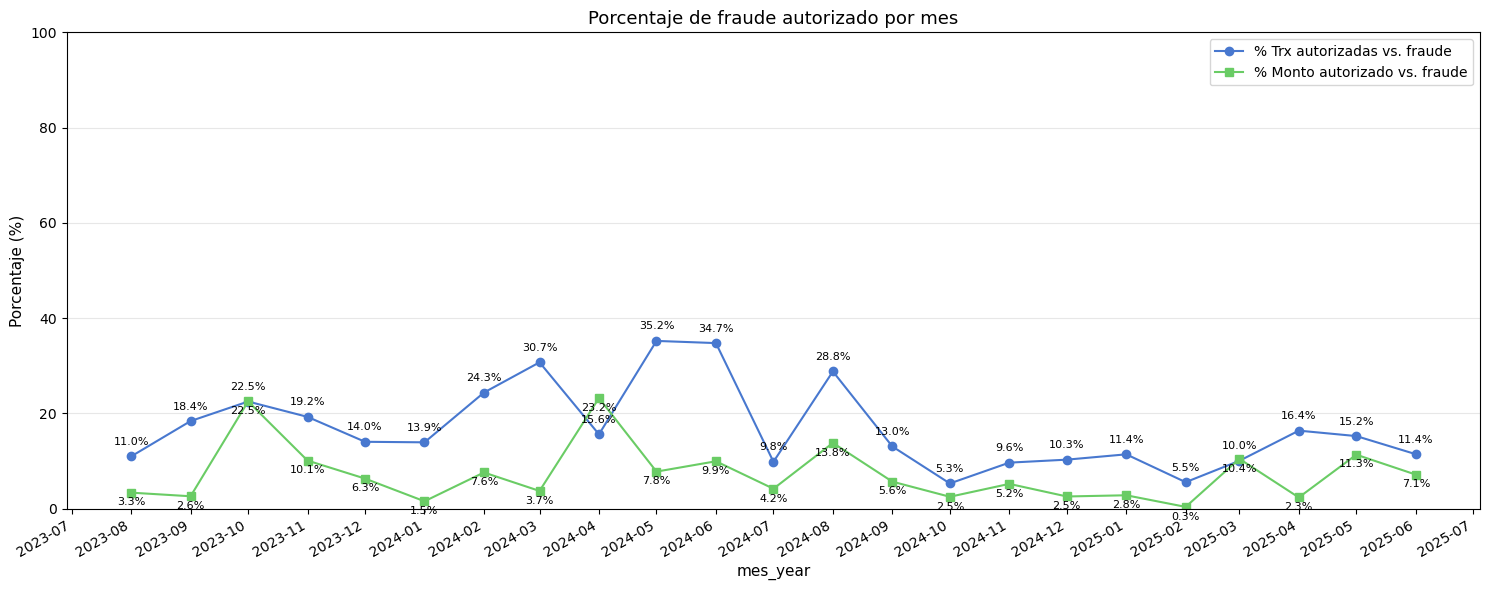

In [204]:

df_plot = tabla_indicador_fraudes.copy()

# --- asegurar que 'mes_year' exista como columna ---
if columna_filtro_f not in df_plot.columns:
    df_plot = df_plot.reset_index()

# --- convertir Period -> Timestamp (YYYY-MM-01) o cadenas -> datetime ---
if is_period_dtype(df_plot[columna_filtro_f]):
    df_plot[columna_filtro_f] = df_plot[columna_filtro_f].dt.to_timestamp()
else:
    df_plot[columna_filtro_f] = pd.to_datetime(df_plot[columna_filtro_f], errors='coerce')

# ordenar por fecha
df_plot = df_plot.sort_values(columna_filtro_f)

# asegurar % en 0–100
for c in ['pct_trx_aut_sobre_fraude', 'pct_monto_aut_sobre_fraude']:
    df_plot[c] = pd.to_numeric(df_plot[c], errors='coerce')
    if df_plot[c].max() is not np.nan and df_plot[c].max() <= 1:
        df_plot[c] = df_plot[c] * 100

plt.figure(figsize=(15,6))
# Graficar líneas
plt.plot(df_plot[columna_filtro_f], df_plot['pct_trx_aut_sobre_fraude'], marker='o', label='% Trx autorizadas vs. fraude')
plt.plot(df_plot[columna_filtro_f], df_plot['pct_monto_aut_sobre_fraude'], marker='s', label='% Monto autorizado vs. fraude')

# Etiquetas sobre cada punto de la serie 1
for x, y in zip(df_plot[columna_filtro_f], df_plot['pct_trx_aut_sobre_fraude']):
    if not np.isnan(y):
        plt.text(x, y+2, f'{y:.1f}%', ha='center', va='bottom', fontsize=8)

# Etiquetas sobre cada punto de la serie 2
for x, y in zip(df_plot[columna_filtro_f], df_plot['pct_monto_aut_sobre_fraude']):
    if not np.isnan(y):
        plt.text(x, y-1, f'{y:.1f}%', ha='center', va='top', fontsize=8)

plt.title('Porcentaje de fraude autorizado por mes')
plt.xlabel(columna_filtro_f)
plt.ylabel('Porcentaje (%)')
plt.ylim(0, 100)
plt.grid(True, axis='y', alpha=0.3)
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()



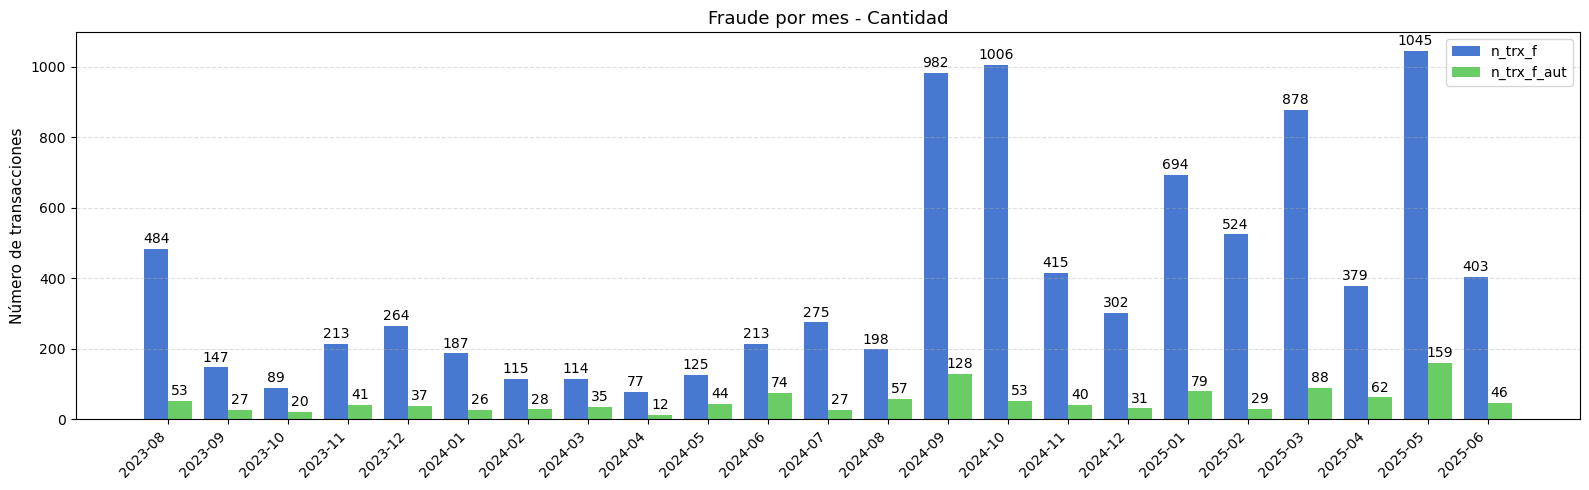

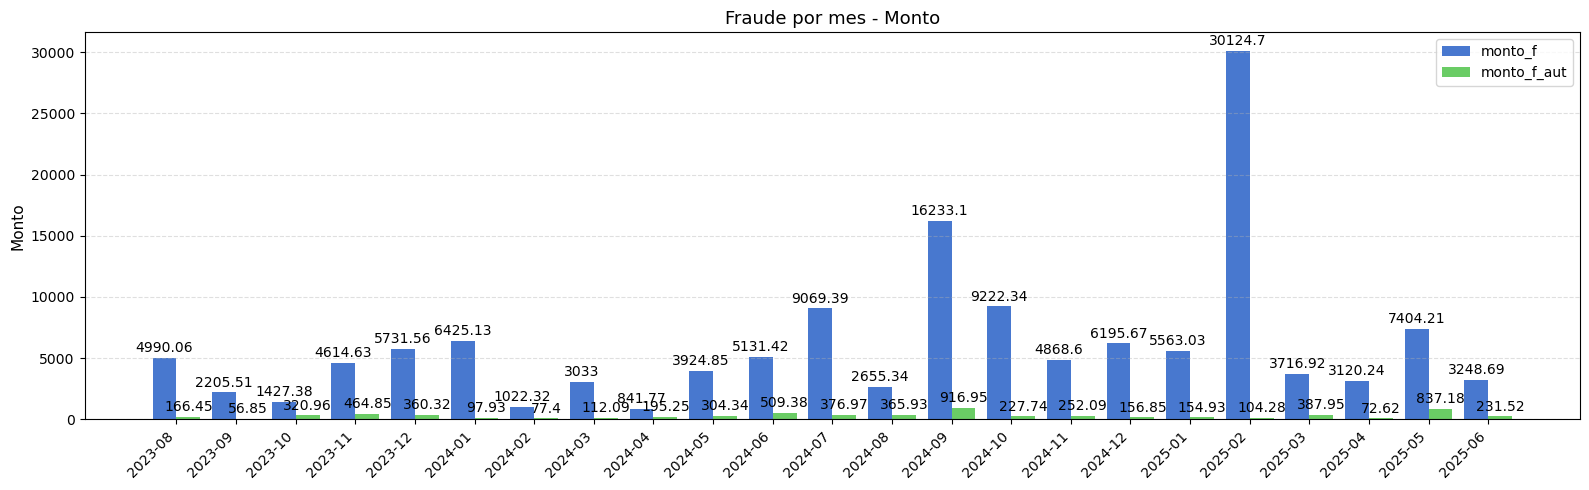

C:\Users\xavie\AppData\Local\Temp\ipykernel_7228\2710806457.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



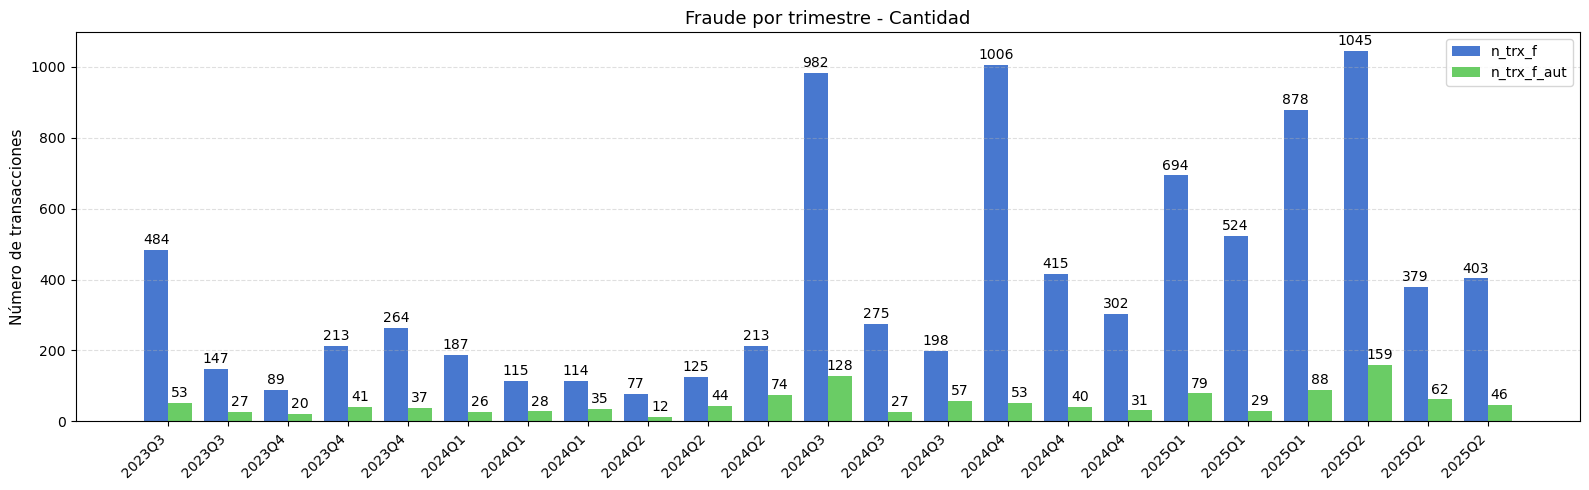

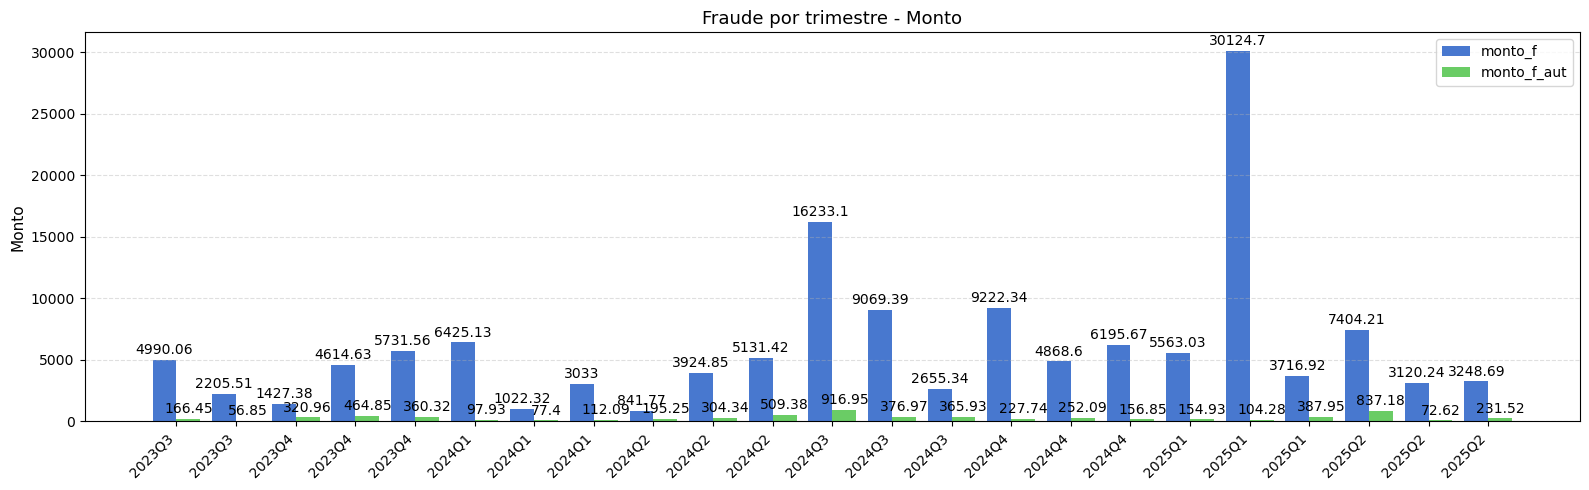

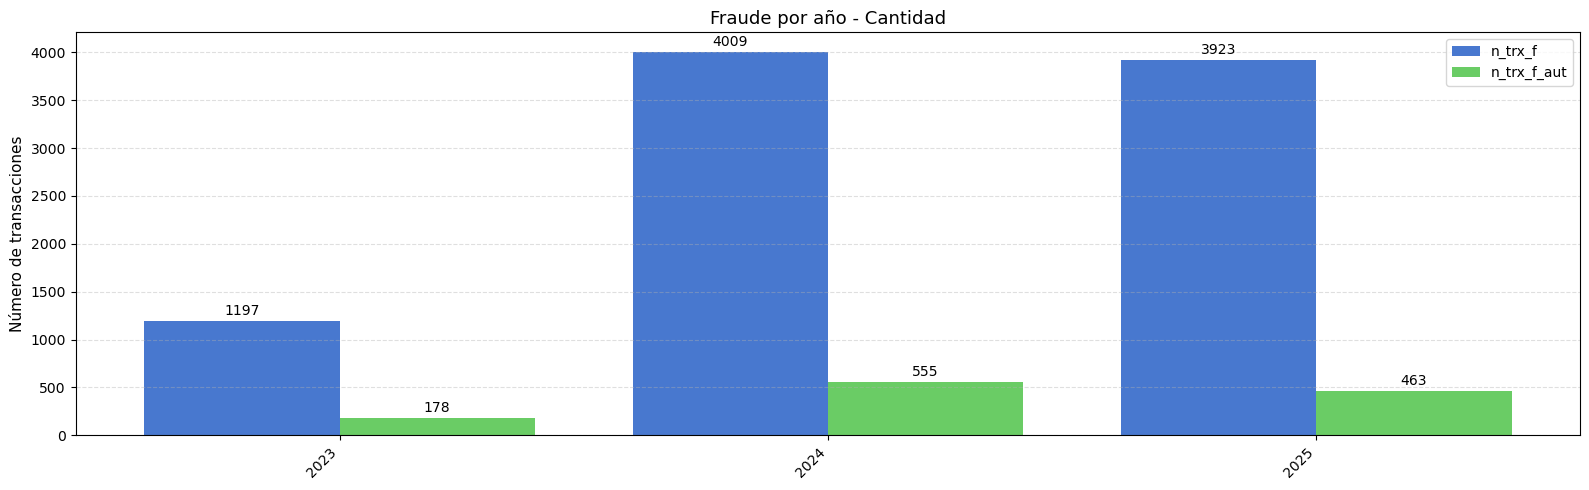

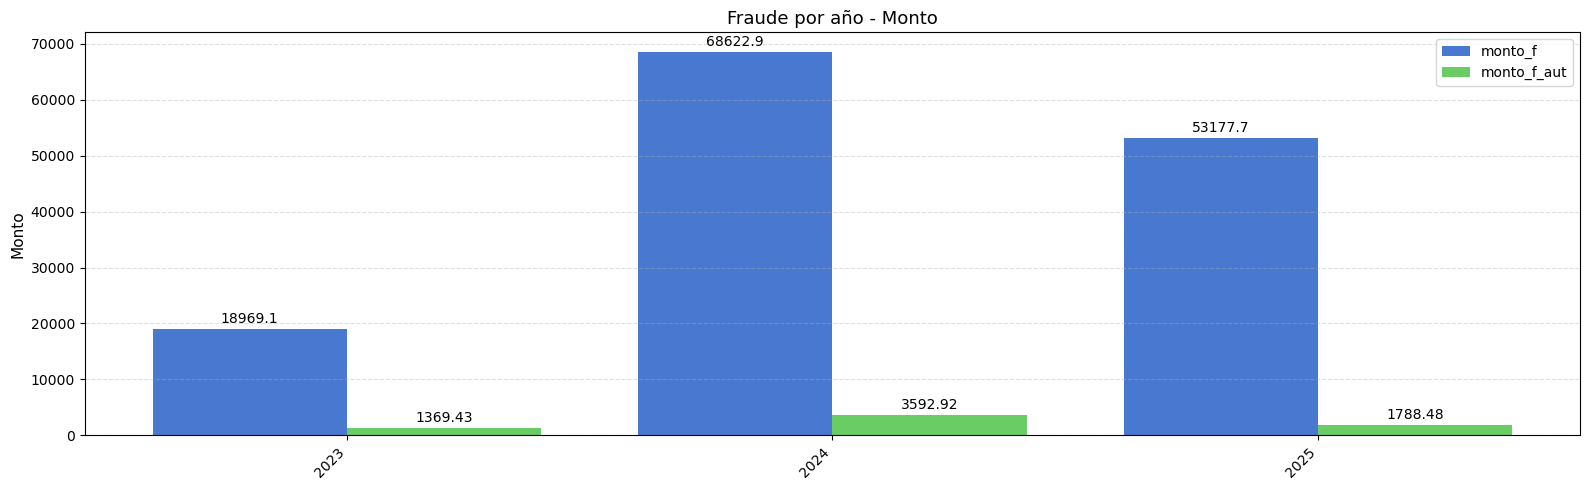

In [205]:

def _ordenar_periodos(df, period_col):
    """Intenta ordenar cronológicamente; si no se puede, respeta el orden actual."""
    x = df[period_col].astype(str)
    # intento 1: Periodos tipo YYYY-MM
    try:
        orden = pd.to_datetime(x.str[:7] + "-01")
        return df.loc[orden.sort_values().index]
    except Exception:
        pass
    # intento 2: trimestres tipo 2024Q1 / 2024-Q1
    try:
        orden = pd.PeriodIndex(x.str.replace("-", ""), freq="Q")
        return df.loc[pd.Series(orden).sort_values().index]
    except Exception:
        pass
    # intento 3: año
    try:
        orden = pd.to_numeric(x)
        return df.loc[orden.sort_values().index]
    except Exception:
        pass
    return df

def graficar_barras_fraude(
    df,
    period_col="mes_year",
    col_n_total="n_trx_f",
    col_n_aut="n_trx_f_aut",
    col_m_total="monto_f",
    col_m_aut="monto_f_aut",
    titulo_base="Comparativo fraude"
):
    """
    Genera 2 gráficos de barras:
      1) Cantidad de transacciones: n_trx_f vs n_trx_f_aut
      2) Monto: monto_f vs monto_f_aut
    Las barras ahora muestran etiquetas de valores encima.
    """
    cols_necesarias = [period_col, col_n_total, col_n_aut, col_m_total, col_m_aut]
    faltantes = [c for c in cols_necesarias if c not in df.columns]
    if faltantes:
        raise ValueError(f"Faltan columnas en el DataFrame: {faltantes}")

    data = df[cols_necesarias].copy().fillna(0)
    data = _ordenar_periodos(data, period_col)

    categorias = data[period_col].astype(str).tolist()
    idx = np.arange(len(categorias))
    width = 0.4

    # --- Gráfico 1: Cantidades ---
    fig1, ax1 = plt.subplots(figsize=(16, 5))
    rects1 = ax1.bar(idx - width/2, data[col_n_total].values, width, label=col_n_total)
    rects2 = ax1.bar(idx + width/2, data[col_n_aut].values, width, label=col_n_aut)
    ax1.set_xticks(idx)
    ax1.set_xticklabels(categorias, rotation=45, ha="right")
    ax1.set_ylabel("Número de transacciones")
    ax1.set_title(f"{titulo_base} - Cantidad")
    ax1.legend()
    ax1.grid(axis="y", linestyle="--", alpha=0.4)
    # Etiquetas en las barras
    ax1.bar_label(rects1, padding=2, fontsize=10)
    ax1.bar_label(rects2, padding=2, fontsize=10)
    plt.tight_layout()
    plt.show()

    # --- Gráfico 2: Montos ---
    fig2, ax2 = plt.subplots(figsize=(16, 5))
    rects3 = ax2.bar(idx - width/2, data[col_m_total].values, width, label=col_m_total)
    rects4 = ax2.bar(idx + width/2, data[col_m_aut].values, width, label=col_m_aut)
    ax2.set_xticks(idx)
    ax2.set_xticklabels(categorias, rotation=45, ha="right")
    ax2.set_ylabel("Monto")
    ax2.set_title(f"{titulo_base} - Monto")
    ax2.legend()
    ax2.grid(axis="y", linestyle="--", alpha=0.4)
    # Etiquetas en las barras
    ax2.bar_label(rects3, padding=2, fontsize=10)
    ax2.bar_label(rects4, padding=2, fontsize=10)
    plt.tight_layout()
    plt.show()

# 1) Por mes (ya tienes 'mes_year')
graficar_barras_fraude(tabla_indicador_fraudes, period_col="mes_year",
                       titulo_base="Fraude por mes")

# 2) Por trimestre (asegura que 'mes_year' es string antes de concatenar)
tabla_indicador_fraudes = tabla_indicador_fraudes.copy()
tabla_indicador_fraudes["trimestre"] = (
    pd.to_datetime(tabla_indicador_fraudes["mes_year"].astype(str) + "-01")
      .dt.to_period("Q").astype(str)
)
graficar_barras_fraude(tabla_indicador_fraudes, period_col="trimestre",
                       titulo_base="Fraude por trimestre")

# 3) Por año (si no lo tienes, créalo a partir de mes_year):
tabla_indicador_fraudes["year"] = (
    pd.to_datetime(tabla_indicador_fraudes["mes_year"].astype(str) + "-01").dt.year
)
tabla_anual = (tabla_indicador_fraudes
               .groupby("year", as_index=False)[["n_trx_f","n_trx_f_aut","monto_f","monto_f_aut"]]
               .sum())
graficar_barras_fraude(tabla_anual, period_col="year",
                       titulo_base="Fraude por año")


# Indicador: Puntos base (pb) de fraude

Los puntos base cuantifican la tasa de pérdida por fraude autorizado sobre el monto procesado. Es un indicador de frecuencia-impacto normalizado que permite comparar meses, canales y campañas aun cuando los volúmenes transaccionales cambian.

Fórmula.

$$
\text{pb}_{\text{fraude},\,t}
= \frac{\text{monto\_fraude\_aut}_{t}}{\text{monto\_procesado}_{t}}
\times 10{,}000
$$

Un punto base de fraude representa la cantidad de pérdida monetaria por cada 10,000 unidades monetarias procesadas en transacciones. Es decir, indica cuánto se pierde a causa de fraude por cada 10,000 procesados, permitiendo medir y comparar el impacto relativo del fraude de manera sencilla y estandarizada.



## Detalle:

- 9.129 alertas de fraude; monto total ≈ USD 140,8k.
- CNP no presencial no autorizado concentra el riesgo: ≈87% de eventos y ≈95% del monto.
- Fraude CNP autorizado: 1.187 eventos (≈13%) por ≈USD 6,3k.

## Puntos Base de Fraude Bruto (CP + CNP combinados)

La primer metrica de Puntos Base combina los canales presencial (CP) y no presente (CNP) muestra la exposición global al fraude autorizado respecto al total de monto procesado por el emisor.

- El indicador de puntos base de fraude bruto evidencia variaciones mensuales, con picos asociados generalmente a periodos de alta actividad o eventos especiales.
- Altos valores señalan momentos de mayor vulnerabilidad sistémica general, mientras que descensos sugieren mejoras en la gestión, como actualización de parámetros antifraude o reforzamiento de políticas.
- Al normalizarse respecto al monto procesado, permite comparar diferentes periodos y realizar benchmarking interno año tras año.
- Es útil para evaluar la eficacia general de la estrategia antifraude, así como para decidir la asignación de recursos en el monitoreo de ambos canales de manera consolidada.

## Puntos Base de Fraude Bruto – Canal No Presente (CNP)

Cuando el análisis se segmenta exclusivamente al canal no presencial (CNP), se obtiene una visión mucho más focalizada sobre el riesgo asociado a transacciones online y sin tarjeta física.

- El CNP muestra históricamente mayores puntos base respecto al CP, ya que las transacciones remotas son más susceptibles a fraudes debido a la ausencia de verificación física.
- Se identifican picos destacados (ej. en 2024-08 y 2024-09), indicando posibles incidentes coordinados, nuevas modalidades de fraude o fallos puntuales en los controles de fraude.
- Importancia del enfoque: Segmentar el indicador por canal permite priorizar estrategias y recursos en los puntos más vulnerables y diseñar controles específicos para el entorno digital.

Tras eventos de fraude elevados y la aplicación de medidas correctivas, suele observarse una reducción posterior en el indicador, evidenciando el impacto de las acciones implantadas.


# Fraude total Bruto



In [206]:
# Fraude Bruto = Total de fraude (autorizado) que afecta a la organizaciòn sin  importar quien debe afrontar.

display(tabla_fraudes_aut_suma.transpose())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
mes_year,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06
monto_f_aut,166.45,56.85,320.96,464.85,360.32,97.93,77.4,112.09,195.25,304.34,509.38,376.97,365.93,916.95,227.74,252.09,156.85,154.93,104.28,387.95,72.62,837.18,231.52


# Puntos base

In [207]:
# Monto procesado

tabla_monto_procesado = (
    df.groupby(columna_filtro_f)['DE6_Monto_Dolar']
    .sum()
    .reset_index()
    .rename(columns={
        'DE6_Monto_Dolar' : 'monto_procesado'
    })
)
display(tabla_monto_procesado.transpose())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
mes_year,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06
monto_procesado,3270654.02,2562972.97,2811789.31,3289788.69,3431273.36,2885938.3,2846797.78,2924722.17,2551709.72,2481926.25,2366572.88,2347775.39,2555603.09,2231978.49,2254368.6,2165794.99,2448293.4,2200294.53,2216762.21,2222192.93,2293776.07,2381405.91,2290200.38


In [208]:
df_puntos_base_calculo = tabla_fraudes_aut_suma[[columna_filtro_f,'monto_f_aut']].merge(tabla_monto_procesado[[columna_filtro_f,'monto_procesado']]
                                                                                                   , on = columna_filtro_f )

df_puntos_base_calculo['puntos_base_fraude_bruto'] = (df_puntos_base_calculo['monto_f_aut']/df_puntos_base_calculo['monto_procesado']*10000).round(2)
display(df_puntos_base_calculo.transpose())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
mes_year,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06
monto_f_aut,166.45,56.85,320.96,464.85,360.32,97.93,77.4,112.09,195.25,304.34,509.38,376.97,365.93,916.95,227.74,252.09,156.85,154.93,104.28,387.95,72.62,837.18,231.52
monto_procesado,3270654.02,2562972.97,2811789.31,3289788.69,3431273.36,2885938.3,2846797.78,2924722.17,2551709.72,2481926.25,2366572.88,2347775.39,2555603.09,2231978.49,2254368.6,2165794.99,2448293.4,2200294.53,2216762.21,2222192.93,2293776.07,2381405.91,2290200.38
puntos_base_fraude_bruto,0.51,0.22,1.14,1.41,1.05,0.34,0.27,0.38,0.77,1.23,2.15,1.61,1.43,4.11,1.01,1.16,0.64,0.7,0.47,1.75,0.32,3.52,1.01


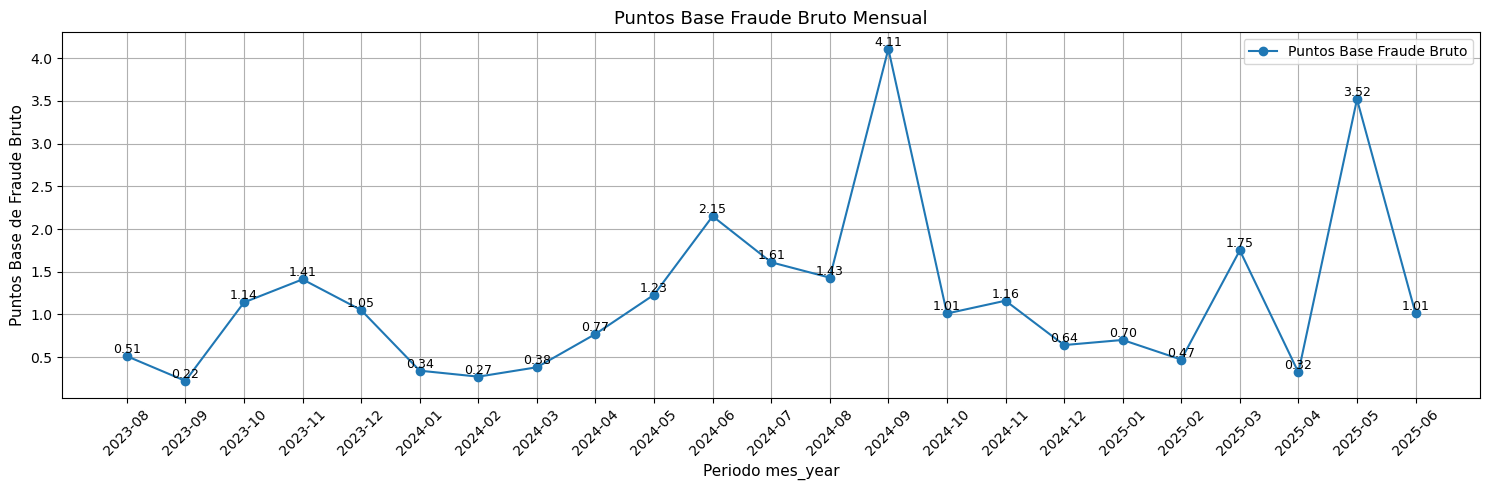

In [209]:
x = df_puntos_base_calculo[columna_filtro_f].astype(str)
y = df_puntos_base_calculo['puntos_base_fraude_bruto']



plt.figure(figsize=(15, 5))
plt.plot(x, y, marker='o', linestyle='-', color='tab:blue', label='Puntos Base Fraude Bruto')
plt.title('Puntos Base Fraude Bruto Mensual')
plt.xlabel(f'Periodo {columna_filtro_f}')
plt.ylabel('Puntos Base de Fraude Bruto')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Agregar etiquetas en cada punto
for i, valor in enumerate(y):
    plt.text(x[i], valor, f'{valor:.2f}', ha='center', va='bottom', fontsize=9, color='black')

plt.show()


# Puntos base fraude bruto Canal no presente (CNP)  



In [210]:
df['mes_year'] = df['mes_year'].astype(str)
df['year'] = df['year'].astype(str)
df['trimestre'] = df['trimestre'].astype(str)


tabla_monto_procesado_cnp = (
    df[df['canal']=='CNP']
    .groupby(columna_filtro_f)['DE6_Monto_Dolar']
    .sum()
    .reset_index()
    .rename(columns={
        'DE6_Monto_Dolar' : 'monto_procesado_cnp'
    })
)
display(tabla_monto_procesado_cnp.transpose())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
mes_year,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06
monto_procesado_cnp,379996.64,284225.53,280829.25,342063.17,301556.73,317659.17,372309.25,301980.26,246515.86,209309.86,227604.52,283529.23,310063.39,293888.68,266555.45,238127.73,259194.34,328199.17,437565.53,357666.05,396216.85,418313.98,404196.95


In [211]:
tabla_monto_autorizado_f_cnp = (
    df_filtrado_f[
        (df_filtrado_f['canal'] == 'CNP') & (df_filtrado_f['Respuesta'] == 'AUTORIZADO')
    ]
    .groupby(columna_filtro_f)['DE6_Monto_Dolar']
    .sum()
    .reset_index()
    .rename(columns={'DE6_Monto_Dolar': 'monto_f_aut_cnp'})
)
display(tabla_monto_autorizado_f_cnp.transpose())


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
mes_year,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06
monto_f_aut_cnp,166.45,56.85,320.96,464.85,360.32,97.93,77.4,101.59,45.25,261.62,509.38,376.97,365.93,916.95,227.74,197.09,156.85,154.93,104.28,387.95,72.62,676.19,231.52


In [212]:
df_puntos_base_calculo_cnp = tabla_monto_autorizado_f_cnp[[columna_filtro_f,'monto_f_aut_cnp']].merge(tabla_monto_procesado_cnp[[columna_filtro_f,'monto_procesado_cnp']]
                                                                                                   , on = columna_filtro_f )

df_puntos_base_calculo_cnp['puntos_base_fraude_bruto_cnp'] = (df_puntos_base_calculo_cnp['monto_f_aut_cnp']/df_puntos_base_calculo_cnp['monto_procesado_cnp']*10000).round(2)
display(df_puntos_base_calculo_cnp.transpose())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
mes_year,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06
monto_f_aut_cnp,166.45,56.85,320.96,464.85,360.32,97.93,77.4,101.59,45.25,261.62,509.38,376.97,365.93,916.95,227.74,197.09,156.85,154.93,104.28,387.95,72.62,676.19,231.52
monto_procesado_cnp,379996.64,284225.53,280829.25,342063.17,301556.73,317659.17,372309.25,301980.26,246515.86,209309.86,227604.52,283529.23,310063.39,293888.68,266555.45,238127.73,259194.34,328199.17,437565.53,357666.05,396216.85,418313.98,404196.95
puntos_base_fraude_bruto_cnp,4.38,2.0,11.43,13.59,11.95,3.08,2.08,3.36,1.84,12.5,22.38,13.3,11.8,31.2,8.54,8.28,6.05,4.72,2.38,10.85,1.83,16.16,5.73


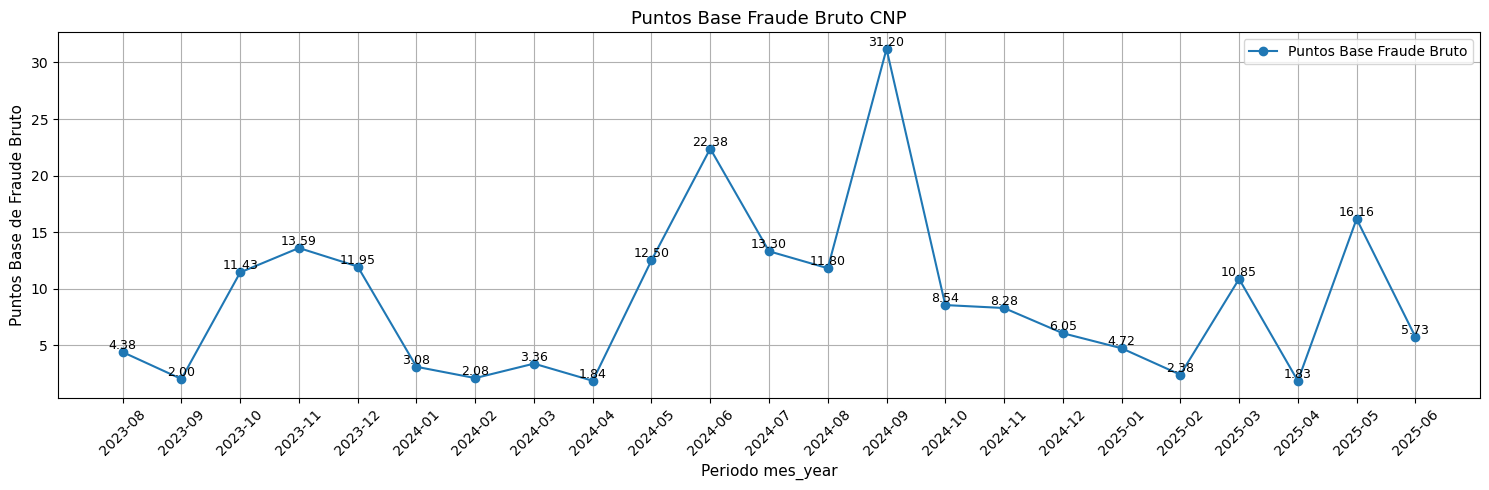

In [213]:
x = df_puntos_base_calculo_cnp[columna_filtro_f].astype(str)
y = df_puntos_base_calculo_cnp['puntos_base_fraude_bruto_cnp']

plt.figure(figsize=(15, 5))
plt.plot(x, y, marker='o', linestyle='-', color='tab:blue', label='Puntos Base Fraude Bruto')
plt.title('Puntos Base Fraude Bruto CNP')
plt.xlabel(f'Periodo {columna_filtro_f}')
plt.ylabel('Puntos Base de Fraude Bruto')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Agregar etiquetas en cada punto
for i, valor in enumerate(y):
    plt.text(x[i], valor, f'{valor:.2f}', ha='center', va='bottom', fontsize=9, color='black')

plt.show()